### 데이터 전처리

1. remove_null_columns(df), remove_single_value_columns(df) 함수 사용
2. failure disk 데이터들에 대해서, linear interpolate
3. 각 failure disk 별로 고장난 날짜 포함 10일에 대해서,timeseries clustering 하려고 함.
4. 처음 관측된 날짜와 fail이 일어난 날짜와의 차이가 9(10-1)보다 작으면, failure disk에서 제외시킴.
5. fail이 일어나기 이전 9일전 + fail이 일어난 날(총 10일) 데이터를 생성(=to_cluster_data)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from sklearn.metrics import silhouette_score
import mglearn

## DTW Kmeans(30일에 대해서)

In [3]:
data = pd.read_csv('../../ssd_data/combined_by_diskmodel/combined_MB1.csv',index_col=False)

# 데이터를 시간 순서대로 정렬 ('ds' 컬럼을 기준으로)
data = data.sort_values(by=['ds'])
data = data.drop_duplicates(subset=['disk_id', 'ds'])
data.reset_index(inplace=True)
del(data['index'])
del(data['level_0'])
data

,disk_id,ds,model,n_1,r_1,n_5,r_5,n_9,r_9,n_12,...,r_244,n_245,r_245,n_175,r_175,n_232,r_232,label,n_211,r_211
0,10005,20190101,MB1,NaN,NaN,100.0,0.0,99.0,4600.0,99.0,...,0.0,100.0,65535.0,NaN,NaN,NaN,NaN,0,NaN,NaN
1,39138,20190101,MB1,NaN,NaN,100.0,0.0,97.0,13256.0,99.0,...,0.0,100.0,65535.0,NaN,NaN,NaN,NaN,0,NaN,NaN
2,3918,20190101,MB1,NaN,NaN,100.0,0.0,97.0,13305.0,99.0,...,0.0,100.0,65535.0,NaN,NaN,NaN,NaN,0,NaN,NaN
3,39187,20190101,MB1,NaN,NaN,100.0,0.0,97.0,12934.0,99.0,...,0.0,100.0,65535.0,NaN,NaN,NaN,NaN,0,NaN,NaN
4,39189,20190101,MB1,NaN,NaN,100.0,0.0,97.0,12934.0,99.0,...,0.0,100.0,65535.0,NaN,NaN,NaN,NaN,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7132648,27627,20190630,MB1,NaN,NaN,100.0,0.0,96.0,17027.0,99.0,...,0.0,100.0,65535.0,NaN,NaN,NaN,NaN,0,NaN,NaN
7132649,27631,20190630,MB1,NaN,NaN,100.0,0.0,96.0,17027.0,99.0,...,0.0,100.0,65535.0,NaN,NaN,NaN,NaN,0,NaN,NaN
7132650,27676,20190630,MB1,NaN,NaN,100.0,0.0,96.0,18069.0,99.0,...,0.0,100.0,65535.0,NaN,NaN,NaN,NaN,0,NaN,NaN
7132651,27586,20190630,MB1,NaN,NaN,100.0,0.0,98.0,8476.0,99.0,...,0.0,100.0,65535.0,NaN,NaN,NaN,NaN,0,NaN,NaN


In [4]:
# null값이 있는 열을 제거하는 코드
def remove_null_columns(df):
    # null인 컬럼을 확인하고, 모든 값이 null인 컬럼을 찾습니다.
    null_columns = df.columns[df.isnull().all()]
    
    # 모든 값이 null인 컬럼을 DataFrame에서 제거합니다.
    df = df.drop(null_columns, axis=1)
    
    return df
# 하나의 unique한 값으로만 이루어진 컬럼을 제거하는 코드
def remove_single_value_columns(df):
    single_value_cols = []
    for col in df.columns:
        unique_values = df[col].nunique()
        if unique_values == 1:
            single_value_cols.append(col)

    df_filtered = df.drop(single_value_cols, axis=1)
    return df_filtered


In [5]:
data = remove_null_columns(data)
data = remove_single_value_columns(data)

failed된 disk_id중에서 첫 관측에서 마지막 관측의 결측치 채우기<br>
interpolate-linear

In [6]:
selected_disk_ids = data[data['label']==1]['disk_id'].unique()

dfs_to_concat = []  # 추가할 데이터프레임들을 저장할 리스트

for disk_id in selected_disk_ids:
    disk_data = data[data['disk_id'] == disk_id].copy()
    disk_data['ds'] = pd.to_datetime(disk_data['ds'], format='%Y%m%d')
    disk_data = disk_data.sort_values(by='ds')
    disk_data = disk_data.set_index('ds', drop=True)
    all_dates = pd.date_range(start=disk_data.index.min(), end=disk_data.index.max(), freq='D')
    disk_data = disk_data.reindex(all_dates)
    disk_data = disk_data.interpolate(method='linear')
    dfs_to_concat.append(disk_data)

interpolated_data = pd.concat(dfs_to_concat)  # 데이터프레임들을 연결하여 새로운 데이터프레임 생성

interpolated_data = interpolated_data.reset_index()  # 인덱스 재설정
interpolated_data

,index,disk_id,n_5,r_5,n_9,r_9,n_12,r_12,n_177,r_177,...,r_194,n_195,r_195,n_199,r_199,n_241,r_241,n_242,r_242,label
0,2019-01-01,17909.0,99.0,2.0,97.0,12819.0,99.0,19.0,97.0,155.0,...,32.0,199.0,1.0,100.0,0.0,99.0,4.761304e+11,99.0,3.422788e+11,1.0
1,2019-01-02,17909.0,99.0,2.0,97.0,12843.0,99.0,19.0,97.0,155.0,...,31.0,199.0,1.0,100.0,0.0,99.0,4.774871e+11,99.0,3.432220e+11,0.0
2,2019-01-03,17909.0,99.0,2.0,97.0,12867.0,99.0,19.0,97.0,156.0,...,31.0,199.0,1.0,100.0,0.0,99.0,4.790559e+11,99.0,3.467700e+11,0.0
3,2019-01-04,17909.0,99.0,2.0,97.0,12891.0,99.0,19.0,97.0,156.0,...,32.0,199.0,1.0,100.0,0.0,99.0,4.805626e+11,99.0,3.477830e+11,0.0
4,2019-01-05,17909.0,99.0,2.0,97.0,12915.0,99.0,19.0,97.0,157.0,...,31.0,199.0,1.0,100.0,0.0,99.0,4.819720e+11,99.0,3.512526e+11,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43895,2019-06-26,8599.0,100.0,0.0,96.0,17168.0,99.0,21.0,91.0,623.0,...,30.0,200.0,0.0,100.0,0.0,99.0,2.201000e+12,99.0,8.356453e+11,0.0
43896,2019-06-27,8599.0,100.0,0.0,96.0,17192.0,99.0,21.0,91.0,623.0,...,30.0,200.0,0.0,100.0,0.0,99.0,2.201312e+12,99.0,8.362658e+11,0.0
43897,2019-06-28,8599.0,100.0,0.0,96.0,17216.0,99.0,21.0,91.0,624.0,...,31.0,200.0,0.0,100.0,0.0,99.0,2.201585e+12,99.0,8.371074e+11,0.0
43898,2019-06-29,8599.0,99.0,2.0,96.0,17240.0,99.0,21.0,91.0,624.0,...,30.0,200.0,0.0,100.0,0.0,99.0,2.201871e+12,99.0,8.379656e+11,0.0


처음관측 됐을때부터 fail이 일어날때까지 30일 이하이면 디스크 아이디를 없앤다

In [7]:
selected_disk_model_1 = interpolated_data['disk_id'].unique()

to_delete_id =[]
for disk_id in selected_disk_model_1:
    disk_data = interpolated_data[interpolated_data['disk_id'] == disk_id].copy()
    disk_data = disk_data.sort_values(by='index')
    disk_data.reset_index(inplace=True,drop=True)

    failed_index = disk_data[disk_data['label']==1]['index'].index.min()
    start_index = disk_data.index.min()

    if(failed_index - start_index) < 29:
        to_delete_id.append(disk_id)

# failed_disk_index에 해당하는 행들을 제거
interploated_data_failed = interpolated_data[~interpolated_data['disk_id'].isin(to_delete_id)]
interploated_data_failed

,index,disk_id,n_5,r_5,n_9,r_9,n_12,r_12,n_177,r_177,...,r_194,n_195,r_195,n_199,r_199,n_241,r_241,n_242,r_242,label
4148,2019-01-01,41400.0,100.0,0.0,97.0,12694.0,99.0,13.0,99.0,55.0,...,31.0,200.0,0.0,100.0,0.0,99.0,1.812450e+11,99.0,1.329623e+11,0.0
4149,2019-01-02,41400.0,100.0,0.0,97.0,12718.0,99.0,13.0,99.0,55.0,...,31.0,200.0,0.0,100.0,0.0,99.0,1.813687e+11,99.0,1.333035e+11,0.0
4150,2019-01-03,41400.0,100.0,0.0,97.0,12742.0,99.0,13.0,99.0,56.0,...,31.0,200.0,0.0,100.0,0.0,99.0,1.815201e+11,99.0,1.336394e+11,0.0
4151,2019-01-04,41400.0,100.0,0.0,97.0,12766.0,99.0,13.0,99.0,56.0,...,31.0,200.0,0.0,100.0,0.0,99.0,1.816743e+11,99.0,1.339799e+11,0.0
4152,2019-01-05,41400.0,100.0,0.0,97.0,12790.0,99.0,13.0,99.0,56.0,...,31.0,200.0,0.0,100.0,0.0,99.0,1.818216e+11,99.0,1.343434e+11,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43895,2019-06-26,8599.0,100.0,0.0,96.0,17168.0,99.0,21.0,91.0,623.0,...,30.0,200.0,0.0,100.0,0.0,99.0,2.201000e+12,99.0,8.356453e+11,0.0
43896,2019-06-27,8599.0,100.0,0.0,96.0,17192.0,99.0,21.0,91.0,623.0,...,30.0,200.0,0.0,100.0,0.0,99.0,2.201312e+12,99.0,8.362658e+11,0.0
43897,2019-06-28,8599.0,100.0,0.0,96.0,17216.0,99.0,21.0,91.0,624.0,...,31.0,200.0,0.0,100.0,0.0,99.0,2.201585e+12,99.0,8.371074e+11,0.0
43898,2019-06-29,8599.0,99.0,2.0,96.0,17240.0,99.0,21.0,91.0,624.0,...,30.0,200.0,0.0,100.0,0.0,99.0,2.201871e+12,99.0,8.379656e+11,0.0


In [8]:
# 라벨이 1인 행을 필터링합니다.
selected_disk_model_1 = interploated_data_failed[interploated_data_failed['label'] == 1]

# 모델, disk_id, 그리고 날짜 순으로 정렬합니다.
selected_disk_model_1 = selected_disk_model_1.sort_values(by=['disk_id', 'index'])

# disk_id와 model 열만을 선택하여 새로운 데이터 프레임에 저장합니다.
selected_disk_model_1 = selected_disk_model_1[['disk_id']].drop_duplicates().reset_index(drop=True)

# 결과 데이터 프레임을 출력합니다.
selected_disk_model_1.shape

(244, 1)

In [9]:
to_cluster_data = pd.DataFrame()

for disk_id in selected_disk_model_1['disk_id'].unique():
    disk_data = interploated_data_failed[interploated_data_failed['disk_id'] == disk_id].copy()
    disk_data = disk_data.sort_values(by='index')
    disk_data.reset_index(inplace=True,drop=True)

    failed_index = disk_data[disk_data['label']==1]['index'].index.min()
    before_9day_index = failed_index - 29

    to_cluster = disk_data.iloc[before_9day_index:failed_index+1, :]
    to_cluster_data = pd.concat([to_cluster_data,to_cluster],axis=0)
    
to_cluster_data

,index,disk_id,n_5,r_5,n_9,r_9,n_12,r_12,n_177,r_177,...,r_194,n_195,r_195,n_199,r_199,n_241,r_241,n_242,r_242,label
54,2019-02-24,470.0,99.0,4.0,96.0,15574.0,99.0,18.0,99.0,7.0,...,29.0,200.0,0.0,100.0,0.0,99.0,1.383236e+10,99.0,8.718806e+09,0.0
55,2019-02-25,470.0,99.0,4.0,96.0,15598.0,99.0,18.0,99.0,7.0,...,29.0,200.0,0.0,100.0,0.0,99.0,1.383236e+10,99.0,8.720226e+09,0.0
56,2019-02-26,470.0,99.0,4.0,96.0,15622.0,99.0,18.0,99.0,7.0,...,29.0,200.0,0.0,100.0,0.0,99.0,1.383236e+10,99.0,8.721518e+09,0.0
57,2019-02-27,470.0,99.0,4.0,96.0,15646.0,99.0,18.0,99.0,7.0,...,29.0,200.0,0.0,100.0,0.0,99.0,1.383236e+10,99.0,8.722888e+09,0.0
58,2019-02-28,470.0,99.0,4.0,96.0,15670.0,99.0,18.0,99.0,7.0,...,29.0,200.0,0.0,100.0,0.0,99.0,1.383236e+10,99.0,8.724136e+09,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,2019-03-21,44338.0,99.0,2.0,96.0,16176.0,99.0,21.0,99.0,6.0,...,31.0,200.0,0.0,100.0,0.0,99.0,1.352326e+10,99.0,8.778025e+09,0.0
80,2019-03-22,44338.0,99.0,2.0,96.0,16200.0,99.0,21.0,99.0,6.0,...,31.0,200.0,0.0,100.0,0.0,99.0,1.352326e+10,99.0,8.779657e+09,0.0
81,2019-03-23,44338.0,99.0,2.0,96.0,16224.0,99.0,21.0,99.0,6.0,...,31.0,200.0,0.0,100.0,0.0,99.0,1.352326e+10,99.0,8.781085e+09,0.0
82,2019-03-24,44338.0,99.0,2.0,96.0,16248.0,99.0,21.0,99.0,6.0,...,31.0,200.0,0.0,100.0,0.0,99.0,1.352326e+10,99.0,8.782419e+09,0.0


In [10]:
to_cluster_fail = to_cluster_data.drop(columns=['index','label'])

grouped = to_cluster_fail.groupby("disk_id").apply(np.array)

to_cluster_fail = np.array(grouped.tolist())  # This is now a 3D array (n_samples, n_timestamps, n_features)
to_cluster_fail = to_cluster_fail[:, :, 1:]
to_cluster_fail.shape

(244, 30, 32)

healthy한 디스크 244개에서 한개씩 가져온다 

In [11]:
import random

# label이 0인 데이터 필터링
filtered_data = data[data['label'] == 0]

# disk_id 중복 제거
unique_disk_ids = filtered_data['disk_id'].unique()

selected_disk_ids = []

# 244개의 disk_id를 랜덤으로 선택
while len(selected_disk_ids) < 244:
    # 아직 선택되지 않은 disk_id들 중 랜덤으로 선택
    remaining_disk_ids = [disk_id for disk_id in unique_disk_ids if disk_id not in selected_disk_ids]
    disk_id = random.choice(remaining_disk_ids)
    
    # 선택된 disk_id의 데이터 추출
    selected_data = data[data['disk_id'] == disk_id]

    # 하나의 disk_id의 행 개수가 180개 이상인 것들
    if len(selected_data) >= 180:
        selected_disk_ids.append(disk_id)


In [12]:
len(selected_disk_ids)

244

In [18]:
# 결과 출력 (selected_disk_ids 리스트에 있는 disk_id의 데이터 추출)
selected_data = data[data['disk_id'].isin(selected_disk_ids)]
selected_data

,disk_id,ds,n_5,r_5,n_9,r_9,n_12,r_12,n_177,r_177,...,r_194,n_195,r_195,n_199,r_199,n_241,r_241,n_242,r_242,label
370,32349,20190101,100.0,0.0,98.0,5311.0,99.0,14.0,99.0,40.0,...,29.0,200.0,0.0,100.0,0.0,99.0,1.445351e+11,99.0,1.184045e+11,0
506,36150,20190101,100.0,0.0,97.0,13302.0,99.0,17.0,99.0,70.0,...,29.0,200.0,0.0,100.0,0.0,99.0,9.093317e+10,99.0,5.660838e+10,0
1231,10782,20190101,100.0,0.0,97.0,13102.0,99.0,17.0,95.0,349.0,...,29.0,200.0,0.0,100.0,0.0,99.0,3.543876e+11,99.0,2.140615e+11,0
1330,10223,20190101,100.0,0.0,99.0,3339.0,99.0,17.0,99.0,6.0,...,32.0,200.0,0.0,100.0,0.0,99.0,1.380439e+10,99.0,1.501553e+10,0
1391,15897,20190101,100.0,0.0,97.0,12770.0,99.0,14.0,99.0,55.0,...,28.0,200.0,0.0,100.0,0.0,99.0,1.626188e+11,99.0,1.238025e+11,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7131926,15588,20190630,100.0,0.0,96.0,16037.0,99.0,20.0,99.0,45.0,...,34.0,200.0,0.0,99.0,1.0,99.0,1.397227e+11,99.0,3.292211e+11,0
7132204,35456,20190630,100.0,0.0,96.0,16810.0,99.0,20.0,97.0,215.0,...,29.0,200.0,0.0,100.0,0.0,99.0,5.984494e+11,99.0,3.954792e+11,0
7132557,28888,20190630,100.0,0.0,96.0,17622.0,99.0,17.0,97.0,161.0,...,30.0,200.0,0.0,100.0,0.0,99.0,2.031765e+11,99.0,1.079733e+11,0
7132615,27384,20190630,100.0,0.0,96.0,17021.0,99.0,16.0,99.0,58.0,...,28.0,200.0,0.0,100.0,0.0,99.0,1.183997e+11,99.0,5.167748e+10,0


In [19]:
dfs_to_concat = []  # 추가할 데이터프레임들을 저장할 리스트

for disk_id in selected_disk_ids:
    disk_data = data[data['disk_id'] == disk_id].copy()
    disk_data['ds'] = pd.to_datetime(disk_data['ds'], format='%Y%m%d')
    disk_data = disk_data.sort_values(by='ds')
    disk_data = disk_data.set_index('ds', drop=True)
    all_dates = pd.date_range(start=disk_data.index.min(), end=disk_data.index.max(), freq='D')
    disk_data = disk_data.reindex(all_dates)
    disk_data = disk_data.interpolate(method='linear')
    dfs_to_concat.append(disk_data)

interpolated_data_healthy = pd.concat(dfs_to_concat)  # 데이터프레임들을 연결하여 새로운 데이터프레임 생성

interpolated_data_healthy = interpolated_data_healthy.reset_index()  # 인덱스 재설정
interpolated_data_healthy

,index,disk_id,n_5,r_5,n_9,r_9,n_12,r_12,n_177,r_177,...,r_194,n_195,r_195,n_199,r_199,n_241,r_241,n_242,r_242,label
0,2019-01-01,24323.0,100.0,0.0,98.0,5314.0,99.0,14.0,99.0,58.0,...,30.0,200.0,0.0,100.0,0.0,99.0,2.147348e+11,99.0,1.556774e+11,0.0
1,2019-01-02,24323.0,100.0,0.0,98.0,5338.0,99.0,14.0,99.0,58.0,...,31.0,200.0,0.0,100.0,0.0,99.0,2.156775e+11,99.0,1.563892e+11,0.0
2,2019-01-03,24323.0,100.0,0.0,98.0,5362.0,99.0,14.0,99.0,58.0,...,30.0,200.0,0.0,100.0,0.0,99.0,2.165945e+11,99.0,1.570457e+11,0.0
3,2019-01-04,24323.0,100.0,0.0,98.0,5386.0,99.0,14.0,99.0,58.0,...,30.0,200.0,0.0,100.0,0.0,99.0,2.176493e+11,99.0,1.577871e+11,0.0
4,2019-01-05,24323.0,100.0,0.0,98.0,5410.0,99.0,14.0,99.0,59.0,...,30.0,200.0,0.0,100.0,0.0,99.0,2.187670e+11,99.0,1.585305e+11,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44159,2019-06-26,13643.0,100.0,0.0,96.0,16632.0,99.0,22.0,93.0,516.0,...,28.0,200.0,0.0,99.0,2.0,99.0,1.503712e+12,99.0,8.682066e+11,0.0
44160,2019-06-27,13643.0,100.0,0.0,96.0,16656.0,99.0,22.0,93.0,518.0,...,29.0,200.0,0.0,99.0,2.0,99.0,1.507465e+12,99.0,8.708910e+11,0.0
44161,2019-06-28,13643.0,100.0,0.0,96.0,16680.0,99.0,22.0,93.0,520.0,...,29.0,200.0,0.0,99.0,2.0,99.0,1.511497e+12,99.0,8.737470e+11,0.0
44162,2019-06-29,13643.0,100.0,0.0,96.0,16704.0,99.0,22.0,93.0,521.0,...,29.0,200.0,0.0,99.0,2.0,99.0,1.515541e+12,99.0,8.763923e+11,0.0


In [20]:
disk_data = filtered_data[filtered_data['disk_id'] == 5790.0]
disk_data

,disk_id,ds,n_5,r_5,n_9,r_9,n_12,r_12,n_177,r_177,...,r_194,n_195,r_195,n_199,r_199,n_241,r_241,n_242,r_242,label
22196,5790,20190101,100.0,0.0,97.0,12933.0,99.0,27.0,96.0,284.0,...,32.0,200.0,0.0,100.0,0.0,99.0,7.171349e+11,99.0,4.438803e+11,0
66865,5790,20190102,100.0,0.0,97.0,12957.0,99.0,27.0,96.0,285.0,...,32.0,200.0,0.0,100.0,0.0,99.0,7.183169e+11,99.0,4.446525e+11,0
99274,5790,20190103,100.0,0.0,97.0,12981.0,99.0,27.0,96.0,285.0,...,32.0,200.0,0.0,100.0,0.0,99.0,7.196048e+11,99.0,4.454824e+11,0
136985,5790,20190104,100.0,0.0,97.0,13005.0,99.0,27.0,96.0,286.0,...,32.0,200.0,0.0,100.0,0.0,99.0,7.207343e+11,99.0,4.462582e+11,0
185453,5790,20190105,100.0,0.0,97.0,13029.0,99.0,27.0,96.0,287.0,...,32.0,200.0,0.0,100.0,0.0,99.0,7.217348e+11,99.0,4.469809e+11,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6935826,5790,20190626,100.0,0.0,96.0,17156.0,99.0,27.0,94.0,390.0,...,33.0,200.0,0.0,100.0,0.0,99.0,8.974247e+11,99.0,5.722663e+11,0
6991968,5790,20190627,100.0,0.0,96.0,17180.0,99.0,27.0,94.0,390.0,...,33.0,200.0,0.0,100.0,0.0,99.0,8.986457e+11,99.0,5.731796e+11,0
7034486,5790,20190628,100.0,0.0,96.0,17204.0,99.0,27.0,94.0,391.0,...,33.0,200.0,0.0,100.0,0.0,99.0,8.994951e+11,99.0,5.738259e+11,0
7057858,5790,20190629,100.0,0.0,96.0,17228.0,99.0,27.0,94.0,391.0,...,33.0,200.0,0.0,100.0,0.0,99.0,9.002956e+11,99.0,5.743744e+11,0


In [21]:
selected_data_list = []
unique_disk_ids = interpolated_data_healthy['disk_id'].unique()
for disk_id in unique_disk_ids:
    disk_data = interpolated_data_healthy[interpolated_data_healthy['disk_id'] == disk_id]
    index_list = disk_data.index.tolist()
    start_index = random.choice(index_list[:-29])
    selected_indexes = index_list[index_list.index(start_index):index_list.index(start_index) + 30]
    selected_data = disk_data.loc[selected_indexes]
    selected_data_list.append(selected_data)
result_data = pd.concat(selected_data_list)

In [22]:
result_data

,index,disk_id,n_5,r_5,n_9,r_9,n_12,r_12,n_177,r_177,...,r_194,n_195,r_195,n_199,r_199,n_241,r_241,n_242,r_242,label
28,2019-01-29,24323.0,100.0,0.0,98.0,5986.0,99.0,14.0,99.0,66.0,...,30.0,200.0,0.0,100.0,0.0,99.0,2.461585e+11,99.0,1.798532e+11,0.0
29,2019-01-30,24323.0,100.0,0.0,98.0,6010.0,99.0,14.0,99.0,66.0,...,30.0,200.0,0.0,100.0,0.0,99.0,2.473493e+11,99.0,1.807734e+11,0.0
30,2019-01-31,24323.0,100.0,0.0,98.0,6034.0,99.0,14.0,99.0,67.0,...,29.0,200.0,0.0,100.0,0.0,99.0,2.485562e+11,99.0,1.815938e+11,0.0
31,2019-02-01,24323.0,100.0,0.0,98.0,6058.0,99.0,14.0,99.0,67.0,...,29.0,200.0,0.0,100.0,0.0,99.0,2.497282e+11,99.0,1.824227e+11,0.0
32,2019-02-02,24323.0,100.0,0.0,98.0,6082.0,99.0,14.0,99.0,67.0,...,30.0,200.0,0.0,100.0,0.0,99.0,2.507700e+11,99.0,1.832262e+11,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44018,2019-02-05,13643.0,100.0,0.0,97.0,13248.0,99.0,22.0,96.0,266.0,...,29.0,200.0,0.0,99.0,2.0,99.0,8.778038e+11,99.0,5.401009e+11,0.0
44019,2019-02-06,13643.0,100.0,0.0,97.0,13272.0,99.0,22.0,96.0,267.0,...,29.0,200.0,0.0,99.0,2.0,99.0,8.816175e+11,99.0,5.415818e+11,0.0
44020,2019-02-07,13643.0,100.0,0.0,97.0,13296.0,99.0,22.0,96.0,269.0,...,30.0,200.0,0.0,99.0,2.0,99.0,8.854573e+11,99.0,5.430407e+11,0.0
44021,2019-02-08,13643.0,100.0,0.0,97.0,13320.0,99.0,22.0,96.0,270.0,...,30.0,200.0,0.0,99.0,2.0,99.0,8.893721e+11,99.0,5.446232e+11,0.0


In [23]:
to_cluster_healthy = result_data.drop(columns=['index','label'])

grouped = to_cluster_healthy.groupby("disk_id").apply(np.array)

to_cluster_healthy = np.array(grouped.tolist())  # This is now a 3D array (n_samples, n_timestamps, n_features)
to_cluster_healthy = to_cluster_healthy[:, :, 1:]
to_cluster_healthy.shape

(244, 30, 32)

In [24]:
print(to_cluster_healthy.shape)
print(to_cluster_fail.shape)

(244, 30, 32)
(244, 30, 32)


In [25]:
# 두 개의 데이터를 하나의 (488, 30, 32) 형태로 합치기
combined_data = np.concatenate([to_cluster_healthy, to_cluster_fail], axis=0)
to_cluster=combined_data
print(to_cluster.shape)

(488, 30, 32)


In [26]:
# Scale the data
scaler = TimeSeriesScalerMeanVariance()
data_scaled = scaler.fit_transform(to_cluster)

In [27]:
def calculate_scores(num_clusters, data_scaled):
    km_dtw = TimeSeriesKMeans(n_clusters=num_clusters, metric="dtw")
    clusters = km_dtw.fit_predict(data_scaled)
    silhouette = silhouette_score(data_scaled.reshape(data_scaled.shape[0], -1), clusters)
    inertia = km_dtw.inertia_
    return silhouette, inertia

In [28]:
num_clusters_range = range(2, 11)
silhouette_scores = []
inertia_scores = []

for k in num_clusters_range:
    silhouette, inertia = calculate_scores(k, data_scaled)
    silhouette_scores.append(silhouette)
    inertia_scores.append(inertia)

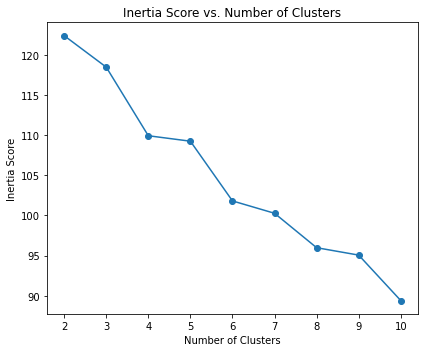

In [29]:
# Plot only the Inertia Score vs. Number of Clusters
plt.figure(figsize=(6, 5))
plt.plot(num_clusters_range, inertia_scores, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia Score")
plt.title("Inertia Score vs. Number of Clusters")
plt.tight_layout()
plt.show()

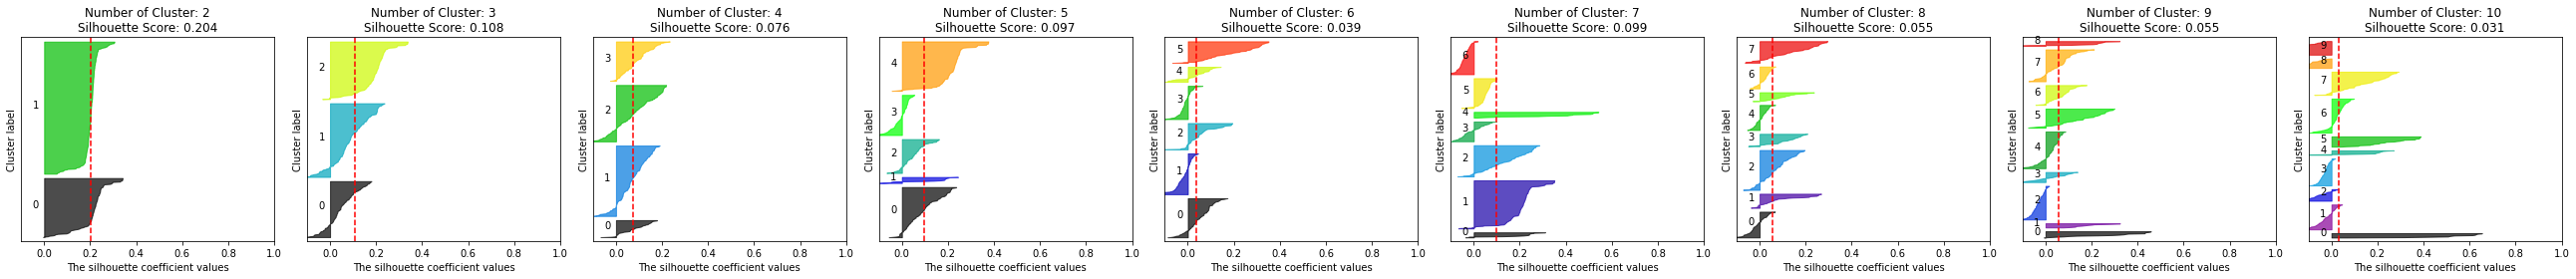

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from sklearn.metrics import silhouette_score, silhouette_samples

# Assuming you have already scaled your time series data (data_scaled) using TimeSeriesScalerMeanVariance
def visualize_silhouette(cluster_lists, data_scaled):
    n_cols = len(cluster_lists)
    fig, axs = plt.subplots(figsize=(4 * n_cols, 4), nrows=1, ncols=n_cols)

    # Flatten the 3-dimensional time series data into 2-dimensional array
    data_reshaped = data_scaled.reshape(data_scaled.shape[0], -1)

    for ind, n_cluster in enumerate(cluster_lists):
        km_dtw = TimeSeriesKMeans(n_clusters=n_cluster, metric="dtw", verbose=False)
        clusters = km_dtw.fit_predict(data_scaled)

        # Calculate the silhouette score on the reshaped data
        silhouette_avg = silhouette_score(data_reshaped, clusters)

        sample_silhouette_values = silhouette_samples(data_reshaped, clusters)
        y_lower = 10

        axs[ind].set_title('Number of Cluster: ' + str(n_cluster) + '\n'
                          'Silhouette Score: ' + str(round(silhouette_avg, 3)))
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(data_scaled) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])

        for i in range(n_cluster):
            ith_cluster_sil_values = sample_silhouette_values[clusters == i]
            ith_cluster_sil_values.sort()

            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = plt.cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values,
                                   facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10

        axs[ind].axvline(x=silhouette_avg, color="red", linestyle="--")

# Example usage with your data_scaled (assuming it's a NumPy array of time series data)
visualize_silhouette(range(2, 11), data_scaled)
plt.tight_layout()
plt.show()

- k= 3

In [31]:
# Choose the number of clusters (k) you want
k = 2

# Run the TimeSeriesKMeans algorithm with DTW distance
km_dtw = TimeSeriesKMeans(n_clusters=k, metric="dtw")
clusters = km_dtw.fit_predict(data_scaled)

In [32]:
clusters

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0,

In [33]:
to_cluster

array([[[1.00000000e+02, 0.00000000e+00, 9.70000000e+01, ...,
         5.40400321e+11, 9.90000000e+01, 6.39636359e+11],
        [1.00000000e+02, 0.00000000e+00, 9.70000000e+01, ...,
         5.41161475e+11, 9.90000000e+01, 6.42341089e+11],
        [1.00000000e+02, 0.00000000e+00, 9.70000000e+01, ...,
         5.41893374e+11, 9.90000000e+01, 6.44867427e+11],
        ...,
        [1.00000000e+02, 0.00000000e+00, 9.70000000e+01, ...,
         5.60054162e+11, 9.90000000e+01, 7.02644384e+11],
        [1.00000000e+02, 0.00000000e+00, 9.70000000e+01, ...,
         5.60885389e+11, 9.90000000e+01, 7.05217489e+11],
        [1.00000000e+02, 0.00000000e+00, 9.70000000e+01, ...,
         5.61622348e+11, 9.90000000e+01, 7.07786965e+11]],

       [[1.00000000e+02, 0.00000000e+00, 9.80000000e+01, ...,
         2.37167837e+11, 9.90000000e+01, 1.84279317e+11],
        [1.00000000e+02, 0.00000000e+00, 9.80000000e+01, ...,
         2.38373574e+11, 9.90000000e+01, 1.85408534e+11],
        [1.00000000e+02, 

In [34]:
fail = to_cluster_data.drop(columns=['index','label'])
healthy = result_data.drop(columns=['index','label'])

In [35]:
# 데이터프레임 행으로 결합 (concat)
to_cluster_data = pd.concat([fail, healthy], ignore_index=True)

to_cluster_data

,disk_id,n_5,r_5,n_9,r_9,n_12,r_12,n_177,r_177,n_180,...,n_194,r_194,n_195,r_195,n_199,r_199,n_241,r_241,n_242,r_242
0,470.0,99.0,4.0,96.0,15574.0,99.0,18.0,99.0,7.0,99.0,...,71.0,29.0,200.0,0.0,100.0,0.0,99.0,1.383236e+10,99.0,8.718806e+09
1,470.0,99.0,4.0,96.0,15598.0,99.0,18.0,99.0,7.0,99.0,...,71.0,29.0,200.0,0.0,100.0,0.0,99.0,1.383236e+10,99.0,8.720226e+09
2,470.0,99.0,4.0,96.0,15622.0,99.0,18.0,99.0,7.0,99.0,...,71.0,29.0,200.0,0.0,100.0,0.0,99.0,1.383236e+10,99.0,8.721518e+09
3,470.0,99.0,4.0,96.0,15646.0,99.0,18.0,99.0,7.0,99.0,...,71.0,29.0,200.0,0.0,100.0,0.0,99.0,1.383236e+10,99.0,8.722888e+09
4,470.0,99.0,4.0,96.0,15670.0,99.0,18.0,99.0,7.0,99.0,...,71.0,29.0,200.0,0.0,100.0,0.0,99.0,1.383236e+10,99.0,8.724136e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14635,13643.0,100.0,0.0,97.0,13248.0,99.0,22.0,96.0,266.0,100.0,...,71.0,29.0,200.0,0.0,99.0,2.0,99.0,8.778038e+11,99.0,5.401009e+11
14636,13643.0,100.0,0.0,97.0,13272.0,99.0,22.0,96.0,267.0,100.0,...,71.0,29.0,200.0,0.0,99.0,2.0,99.0,8.816175e+11,99.0,5.415818e+11
14637,13643.0,100.0,0.0,97.0,13296.0,99.0,22.0,96.0,269.0,100.0,...,70.0,30.0,200.0,0.0,99.0,2.0,99.0,8.854573e+11,99.0,5.430407e+11
14638,13643.0,100.0,0.0,97.0,13320.0,99.0,22.0,96.0,270.0,100.0,...,70.0,30.0,200.0,0.0,99.0,2.0,99.0,8.893721e+11,99.0,5.446232e+11


In [36]:
to_cluster_df = to_cluster_data.copy()
to_cluster_df.reset_index(inplace=True,drop=True)

to_cluster_df['cluster']=0
for i, cluster in enumerate(clusters):
    to_cluster_df.loc[i*30:i*30+30, 'cluster'] = cluster
to_cluster_df

,disk_id,n_5,r_5,n_9,r_9,n_12,r_12,n_177,r_177,n_180,...,r_194,n_195,r_195,n_199,r_199,n_241,r_241,n_242,r_242,cluster
0,470.0,99.0,4.0,96.0,15574.0,99.0,18.0,99.0,7.0,99.0,...,29.0,200.0,0.0,100.0,0.0,99.0,1.383236e+10,99.0,8.718806e+09,1
1,470.0,99.0,4.0,96.0,15598.0,99.0,18.0,99.0,7.0,99.0,...,29.0,200.0,0.0,100.0,0.0,99.0,1.383236e+10,99.0,8.720226e+09,1
2,470.0,99.0,4.0,96.0,15622.0,99.0,18.0,99.0,7.0,99.0,...,29.0,200.0,0.0,100.0,0.0,99.0,1.383236e+10,99.0,8.721518e+09,1
3,470.0,99.0,4.0,96.0,15646.0,99.0,18.0,99.0,7.0,99.0,...,29.0,200.0,0.0,100.0,0.0,99.0,1.383236e+10,99.0,8.722888e+09,1
4,470.0,99.0,4.0,96.0,15670.0,99.0,18.0,99.0,7.0,99.0,...,29.0,200.0,0.0,100.0,0.0,99.0,1.383236e+10,99.0,8.724136e+09,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14635,13643.0,100.0,0.0,97.0,13248.0,99.0,22.0,96.0,266.0,100.0,...,29.0,200.0,0.0,99.0,2.0,99.0,8.778038e+11,99.0,5.401009e+11,1
14636,13643.0,100.0,0.0,97.0,13272.0,99.0,22.0,96.0,267.0,100.0,...,29.0,200.0,0.0,99.0,2.0,99.0,8.816175e+11,99.0,5.415818e+11,1
14637,13643.0,100.0,0.0,97.0,13296.0,99.0,22.0,96.0,269.0,100.0,...,30.0,200.0,0.0,99.0,2.0,99.0,8.854573e+11,99.0,5.430407e+11,1
14638,13643.0,100.0,0.0,97.0,13320.0,99.0,22.0,96.0,270.0,100.0,...,30.0,200.0,0.0,99.0,2.0,99.0,8.893721e+11,99.0,5.446232e+11,1


In [37]:

cluster_0 = to_cluster_df[to_cluster_df['cluster']==0].drop('cluster',axis=1).copy()
cluster_1 = to_cluster_df[to_cluster_df['cluster']==1].drop('cluster',axis=1).copy()
# cluster_2 = to_cluster_df[to_cluster_df['cluster']==2].drop('cluster',axis=1).copy()
""" cluster_3 = to_cluster_df[to_cluster_df['cluster']==3].drop('cluster',axis=1).copy()
cluster_4 = to_cluster_df[to_cluster_df['cluster']==4].drop('cluster',axis=1).copy() """

cluster_0_grouped = cluster_0.groupby(['disk_id']).apply(np.array)
cluster_1_grouped = cluster_1.groupby(['disk_id']).apply(np.array)
# cluster_2_grouped = cluster_2.groupby(['disk_id']).apply(np.array)
""" cluster_3_grouped = cluster_3.groupby(['disk_id']).apply(np.array)
cluster_4_grouped = cluster_4.groupby(['disk_id']).apply(np.array) """

cluster_0_arr = np.array(cluster_0_grouped.tolist())  # This is now a 3D groupby (n_samples, n_timestamps, n_features)
cluster_1_arr = np.array(cluster_1_grouped.tolist())
# cluster_2_arr = np.array(cluster_2_grouped.tolist())
""" cluster_3_arr = np.array(cluster_3_grouped.tolist())
cluster_4_arr = np.array(cluster_4_grouped.tolist())
 """
print('cluster_0_arr 의 shpae:',cluster_0_arr.shape)
print('cluster_1_arr 의 shpae:',cluster_1_arr.shape)
# print('cluster_2_arr 의 shpae:',cluster_2_arr.shape)
""" print('cluster_3_arr 의 shpae:',cluster_3_arr.shape)
print('cluster_4_arr 의 shpae:',cluster_4_arr.shape) """

cluster_0_arr 의 shpae: (151, 30, 33)
cluster_1_arr 의 shpae: (337, 30, 33)


" print('cluster_3_arr 의 shpae:',cluster_3_arr.shape)\nprint('cluster_4_arr 의 shpae:',cluster_4_arr.shape) "

In [38]:
import numpy as np

# Calculate the mean along the first axis
cluster_0_mean_data = np.mean(cluster_0_arr, axis=0)
cluster_1_mean_data = np.mean(cluster_1_arr, axis=0)
# cluster_2_mean_data = np.mean(cluster_2_arr, axis=0)
""" cluster_3_mean_data = np.mean(cluster_3_arr, axis=0)
cluster_4_mean_data = np.mean(cluster_4_arr, axis=0) """

# Now 'mean_data' has shape (10, 33)
print(cluster_0_mean_data.shape)  # Output: (10, 33)

(30, 33)


In [39]:
cluster_0_mean_df = pd.DataFrame(cluster_0_mean_data, columns=cluster_0.columns)
del(cluster_0_mean_df['disk_id'])

cluster_1_mean_df = pd.DataFrame(cluster_1_mean_data, columns=cluster_1.columns)
del(cluster_1_mean_df['disk_id'])

# cluster_2_mean_df = pd.DataFrame(cluster_2_mean_data, columns=cluster_2.columns)
# del(cluster_2_mean_df['disk_id'])

""" cluster_3_mean_df = pd.DataFrame(cluster_3_mean_data, columns=cluster_3.columns)
del(cluster_3_mean_df['disk_id'])

cluster_4_mean_df = pd.DataFrame(cluster_4_mean_data, columns=cluster_4.columns)
del(cluster_4_mean_df['disk_id']) """

" cluster_3_mean_df = pd.DataFrame(cluster_3_mean_data, columns=cluster_3.columns)\ndel(cluster_3_mean_df['disk_id'])\n\ncluster_4_mean_df = pd.DataFrame(cluster_4_mean_data, columns=cluster_4.columns)\ndel(cluster_4_mean_df['disk_id']) "

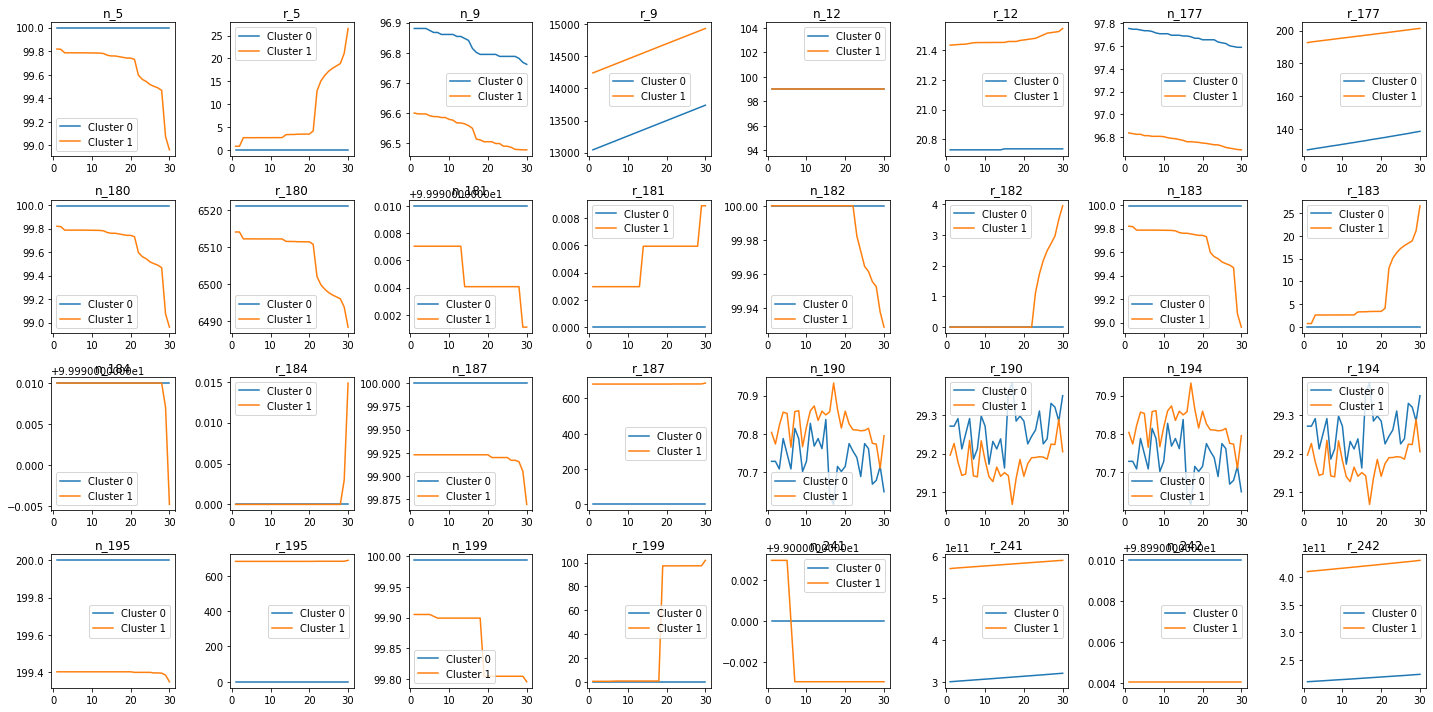

In [42]:
import matplotlib.pyplot as plt

# Assuming the dataframes are named 'cluster_0_mean_df', 'cluster_1_mean_df', 'cluster_2_mean_df', 'cluster_3_mean_df'
clusters = [cluster_0_mean_df, cluster_1_mean_df]
cluster_names = ['Cluster 0', 'Cluster 1','Cluster 2']

# feature names list
feature_names = cluster_0_mean_df.columns.tolist()

# Create subplots with 4 rows and 8 columns, each cell will represent a feature
fig, axs = plt.subplots(nrows=4, ncols=8, figsize=(20, 10))

# Reshape the axes array to 1D for easy iteration
axs = axs.ravel()

for i in range(len(feature_names)):
    for j in range(2):
        # Plot each cluster's line in the same subplot (feature)
        axs[i].plot(clusters[j].index + 1, clusters[j].iloc[:, i], label=cluster_names[j])
        
    axs[i].set_title(feature_names[i])
    axs[i].legend()

plt.tight_layout()
plt.show()

In [47]:
cluster_0['disk_id'].unique()

array([20486., 22927., 22481., 17850., 26324.,  1761., 37657., 38639.,
       36833., 17385., 43839., 39714., 30057., 37215., 36574., 16095.,
       29267.,  8072., 27457., 22679., 27471.,  8282.,  9639., 21894.,
       22975., 15372., 17026., 30056., 38211., 41134., 34534.,   819.,
       17420., 24247., 40937.,  5827., 30436., 40948., 43525.,  7909.,
        3340., 13657., 10821., 25363., 12019.,  7708.,  4668., 43182.,
       17417., 28421., 35894.,  5413., 37605.,  8777., 31448., 35405.,
       14541., 18629., 25468., 32349., 40228.,  5657., 10223., 25193.,
       31759., 17424., 13650., 42855., 36150., 42800., 30715., 30280.,
       33509., 44002., 10699., 21504., 40983.,  9356., 38936.,  9721.,
       20550., 35820., 35456., 24516.,  3803., 43107., 18213., 28687.,
       31691., 34782., 10381., 38434., 21815., 31654., 26602., 19891.,
       20553., 29857., 36970., 10236.,   767., 30430., 30988., 26972.,
       31999.,  2209.,  3899., 43317., 38729., 36919.,   356., 31933.,
      

In [49]:
selected_disk_ids_fail = data[data['label']==1]['disk_id'].unique()
selected_disk_ids_healthy = data[data['label']==0]['disk_id'].unique()
print(len(selected_disk_ids_fail))
print(len(selected_disk_ids_healthy))

304
42343


In [50]:
selected_disk_ids_fail

array([17909, 32240, 44290,  8656, 12584, 24629, 38576,  4848, 25846,
       19500, 43191, 28588,  2432,  3831, 25267,  4040, 19737, 19735,
       19738, 19741, 30277, 39983, 27499, 20085,  2942, 33543,  1850,
       26879, 35780, 30640, 41404, 15351, 34680, 41400, 36234, 36227,
       36225, 36231, 36223, 36235, 36228, 24395, 21593, 38827, 30557,
       31304, 30644, 36232, 30646, 24754, 25535, 36953, 12583, 31804,
       25271, 19420, 19421, 20920,  1881, 12755,  8197, 11952, 20114,
        5351, 29917, 39939, 30827, 18796, 36330, 25624, 13686, 37709,
        9452, 16067, 25063, 34853, 14877, 35737,  5434, 38358, 31295,
       13498, 25764,  3693, 29280, 39655, 28302, 38452, 42935, 42112,
         470,   476, 22336, 42319,  8149, 37476,  5883,  3692,  8789,
       24759,  3686, 22437, 44335, 42311, 39666, 44338, 25763, 37479,
       17817, 17819, 38451,  3688, 42119, 29290, 42313, 22440, 42323,
       37471, 22439, 23056, 23050,  5876, 12786, 12781, 20324, 12613,
       34294, 42309,

In [51]:
import numpy as np

# cluster_0 데이터프레임의 disk_id 열의 고유값들을 가져온다.
cluster_0_unique_disk_ids = cluster_0['disk_id'].unique()

# selected_disk_ids_fail와 selected_disk_ids_healthy를 각각 set으로 변환한다.
selected_disk_ids_fail_set = set(selected_disk_ids_fail)
selected_disk_ids_healthy_set = set(selected_disk_ids_healthy)

# cluster_0_unique_disk_ids에 속하는 디스크 아이디의 개수를 계산한다.
total_disk_ids = len(cluster_0_unique_disk_ids)

# selected_disk_ids_fail와 selected_disk_ids_healthy에 속하는 디스크 아이디의 개수를 계산한다.
fail_disk_ids_count = len(selected_disk_ids_fail_set.intersection(cluster_0_unique_disk_ids))
healthy_disk_ids_count = len(selected_disk_ids_healthy_set.intersection(cluster_0_unique_disk_ids))

# 결과를 출력한다.
print("Total disk IDs in cluster_0:", total_disk_ids)
print("Number of disk IDs in selected_disk_ids_fail:", fail_disk_ids_count)
print("Number of disk IDs in selected_disk_ids_healthy:", healthy_disk_ids_count)

Total disk IDs in cluster_0: 151
Number of disk IDs in selected_disk_ids_fail: 0
Number of disk IDs in selected_disk_ids_healthy: 151


In [53]:
import numpy as np

# cluster_0 데이터프레임의 disk_id 열의 고유값들을 가져온다.
cluster_1_unique_disk_ids = cluster_1['disk_id'].unique()

# selected_disk_ids_fail와 selected_disk_ids_healthy를 각각 set으로 변환한다.
selected_disk_ids_fail_set = set(selected_disk_ids_fail)
selected_disk_ids_healthy_set = set(selected_disk_ids_healthy)

# cluster_0_unique_disk_ids에 속하는 디스크 아이디의 개수를 계산한다.
total_disk_ids = len(cluster_1_unique_disk_ids)

# selected_disk_ids_fail와 selected_disk_ids_healthy에 속하는 디스크 아이디의 개수를 계산한다.
fail_disk_ids_count = len(selected_disk_ids_fail_set.intersection(cluster_1_unique_disk_ids))
healthy_disk_ids_count = len(selected_disk_ids_healthy_set.intersection(cluster_1_unique_disk_ids))

# 결과를 출력한다.
print("Total disk IDs in cluster_0:", total_disk_ids)
print("Number of disk IDs in selected_disk_ids_fail:", fail_disk_ids_count)
print("Number of disk IDs in selected_disk_ids_healthy:", healthy_disk_ids_count)

Total disk IDs in cluster_0: 337
Number of disk IDs in selected_disk_ids_fail: 244
Number of disk IDs in selected_disk_ids_healthy: 337


In [48]:
data.head()

,disk_id,ds,n_5,r_5,n_9,r_9,n_12,r_12,n_177,r_177,...,r_194,n_195,r_195,n_199,r_199,n_241,r_241,n_242,r_242,label
0,10005,20190101,100.0,0.0,99.0,4600.0,99.0,36.0,99.0,5.0,...,27.0,200.0,0.0,100.0,0.0,99.0,2.189215e+09,99.0,2.041073e+09,0
1,39138,20190101,100.0,0.0,97.0,13256.0,99.0,16.0,98.0,143.0,...,30.0,200.0,0.0,100.0,0.0,99.0,4.680026e+11,99.0,3.996304e+11,0
2,3918,20190101,100.0,0.0,97.0,13305.0,99.0,17.0,99.0,71.0,...,31.0,200.0,0.0,100.0,0.0,99.0,9.327556e+10,99.0,5.956923e+10,0
3,39187,20190101,100.0,0.0,97.0,12934.0,99.0,18.0,96.0,244.0,...,31.0,200.0,0.0,100.0,0.0,99.0,6.332917e+11,99.0,3.855869e+11,0
4,39189,20190101,100.0,0.0,97.0,12934.0,99.0,18.0,96.0,237.0,...,30.0,200.0,0.0,100.0,0.0,99.0,6.095518e+11,99.0,3.592685e+11,0


In [27]:
to_cluster_df.to_csv('../../ssd_data/clustering_data/DTW_Kmeans_3.csv')

In [30]:
cluster_0_id= to_cluster_df[to_cluster_df['cluster']==0]['disk_id'].unique()
cluster_1_id= to_cluster_df[to_cluster_df['cluster']==1]['disk_id'].unique()
cluster_2_id= to_cluster_df[to_cluster_df['cluster']==2]['disk_id'].unique()

In [33]:
data[data['disk_id']==cluster_0_id[0]]

,index,disk_id,n_5,r_5,n_9,r_9,n_12,r_12,n_177,r_177,...,r_194,n_195,r_195,n_199,r_199,n_241,r_241,n_242,r_242,label
39776,2019-01-01,601.0,100.0,0.0,97.0,13145.0,99.0,18.0,97.0,188.0,...,26.0,200.0,0.0,100.0,0.0,99.0,6.382424e+11,99.0,4.851654e+11,0.0
39777,2019-01-02,601.0,100.0,0.0,97.0,13169.0,99.0,18.0,97.0,189.0,...,26.0,200.0,0.0,100.0,0.0,99.0,6.410735e+11,99.0,4.870629e+11,0.0
39778,2019-01-03,601.0,100.0,0.0,97.0,13193.0,99.0,18.0,97.0,190.0,...,26.0,200.0,0.0,100.0,0.0,99.0,6.440735e+11,99.0,4.890647e+11,0.0
39779,2019-01-04,601.0,100.0,0.0,97.0,13217.0,99.0,18.0,97.0,191.0,...,26.0,200.0,0.0,100.0,0.0,99.0,6.469741e+11,99.0,4.910458e+11,0.0
39780,2019-01-05,601.0,100.0,0.0,97.0,13241.0,99.0,18.0,97.0,192.0,...,26.0,200.0,0.0,100.0,0.0,99.0,6.498371e+11,99.0,4.930077e+11,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39952,2019-06-26,601.0,99.0,2.0,96.0,17366.0,99.0,18.0,96.0,294.0,...,27.0,200.0,0.0,100.0,0.0,99.0,9.476637e+11,99.0,7.742962e+11,0.0
39953,2019-06-27,601.0,99.0,2.0,96.0,17390.0,99.0,18.0,96.0,294.0,...,27.0,200.0,0.0,100.0,0.0,99.0,9.476637e+11,99.0,7.742962e+11,0.0
39954,2019-06-28,601.0,99.0,2.0,96.0,17414.0,99.0,18.0,96.0,294.0,...,27.0,200.0,0.0,100.0,0.0,99.0,9.476637e+11,99.0,7.742962e+11,0.0
39955,2019-06-29,601.0,99.0,2.0,96.0,17438.0,99.0,18.0,96.0,294.0,...,27.0,200.0,0.0,100.0,0.0,99.0,9.476637e+11,99.0,7.742962e+11,0.0


In [ ]:
import matplotlib.pyplot as plt

# Assuming the dataframes are named 'cluster_0_mean_df', 'cluster_1_mean_df', 'cluster_2_mean_df', 'cluster_3_mean_df'
sample_id = cluster_0_id[0]

# feature names list
feature_names = cluster_0_mean_df.columns.tolist()

# Create subplots with 4 rows and 8 columns, each cell will represent a feature
fig, axs = plt.subplots(nrows=4, ncols=8, figsize=(20, 10))

# Reshape the axes array to 1D for easy iteration
axs = axs.ravel()

for i in range(len(feature_names)):
    # Plot each cluster's line in the same subplot (feature)
    axs[i].plot(clusters[i].index + 1, clusters[i].iloc[:, i])
    axs[i].set_title(feature_names[i])
    axs[i].legend()

plt.tight_layout()
plt.show()

Text(0, 0.5, 'Second principal component')

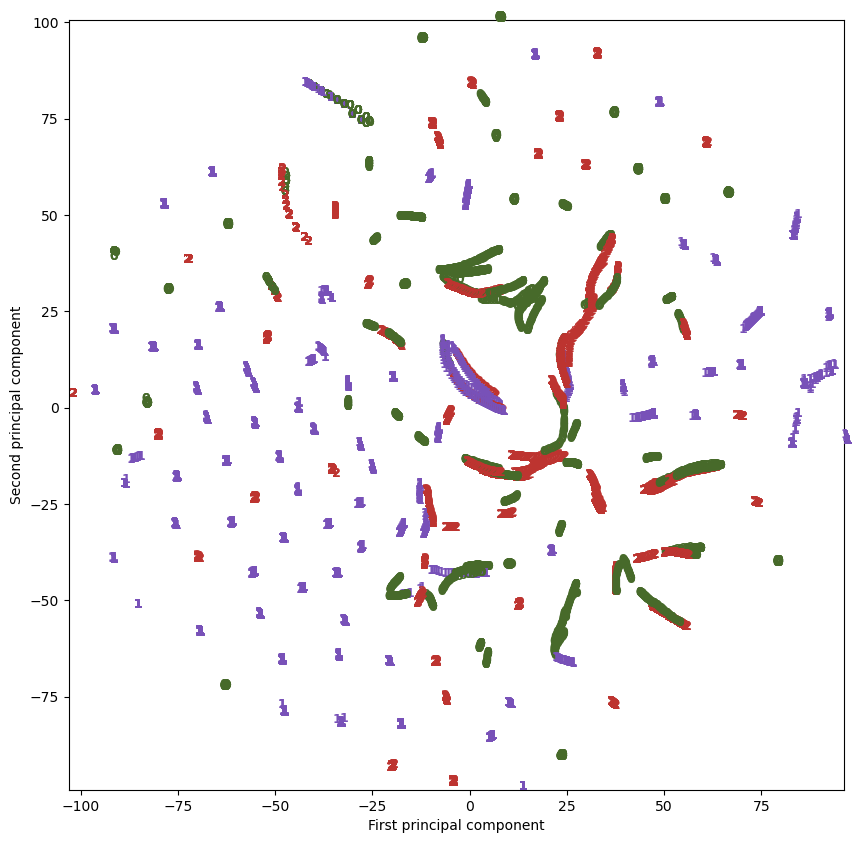

In [28]:
from sklearn.manifold import TSNE

x_data = to_cluster_df.drop(columns=['index','disk_id','label','cluster'])
# dim reduction with tsne
tsne = TSNE(random_state=42)
# use fit_transform instead of fit, as TSNE has no transform method. not be used as preprocessing step of supervised learning
tsne_data = tsne.fit_transform(x_data)
colors = ["#476A2A", "#7851B8", "#BD3430", "#4A2D4E", "#875525",
          "#A83683", "#4E655E", "#853541", "#3A3120", "#535D8E"]
plt.figure(figsize=(10, 10))
plt.xlim(tsne_data[:, 0].min(), tsne_data[:, 0].max())
plt.ylim(tsne_data[:, 1].min(), tsne_data[:, 1].max())
for i in range(len(to_cluster_df)):
    # actually plot the digits as text instead of using scatter
    plt.text(tsne_data[i, 0], tsne_data[i, 1], str(list(to_cluster_df['cluster'])[i]),
             color = colors[list(to_cluster_df['cluster'])[i]],
             fontdict={'weight': 'bold', 'size': 9})
plt.xlabel("First principal component")
plt.ylabel("Second principal component")
#상대적으로 잘 뭉쳐져있다! -> 시각화하는데 잘 사용됨.

In [ ]:
import plotly.graph_objects as go

x_data = to_cluster_df.drop(columns=['index','disk_id','label','cluster'])

# Reduce dimensions with t-SNE
tsne = TSNE(n_components=3, random_state=42) # set n_components to 3 for 3D
tsne_data = tsne.fit_transform(x_data)

# Prepare data for plotly
clusters = list(to_cluster_df['cluster'])
colors = ["#476A2A", "#7851B8", "#BD3430", "#4A2D4E", "#875525",
          "#A83683", "#4E655E", "#853541", "#3A3120", "#535D8E"]
color_map = [colors[i] for i in clusters]

# Create a 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=tsne_data[:, 0],
    y=tsne_data[:, 1],
    z=tsne_data[:, 2],
    mode='markers',
    marker=dict(
        size=5,
        color=color_map,  # set color to an array/list of desired values
    ),
    text=clusters,  # assign the cluster labels as hovertext
)])

# Update layout for better view
fig.update_layout(scene = dict(
                    xaxis_title='First principal component',
                    yaxis_title='Second principal component',
                    zaxis_title='Third principal component'),
                    width=700,
                    margin=dict(r=20, b=10, l=10, t=10))

fig.show()

# 옛날에 한거임, 쓸모없을수도있어서 접어둠

In [4]:
#Scaling 과정
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(label_1)
label_1_scaled = scaler.transform(label_1)

c:\Users\choib\anaconda3\envs\iise-python\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\choib\anaconda3\envs\iise-python\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\choib\anaconda3\envs\iise-python\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\choib\anaconda3\envs\iise-python\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  war

Text(0.5, 1.0, 'K-Means Inertia')

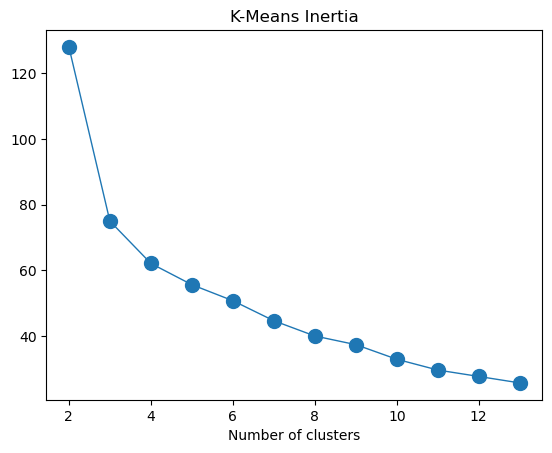

In [5]:
from sklearn.metrics import silhouette_score

from sklearn.cluster import KMeans
'''StandardSclaer를 사용하여 진행''' 

inertia=[]
kmeans_sil_scores=[]
for n_cluster in range(2,14):
    kmeans = KMeans(n_clusters=n_cluster, random_state=0)
    cluster_labels = kmeans.fit_predict(label_1_scaled)

    inertia.append(kmeans.inertia_)
    kmeans_sil_scores.append(silhouette_score(label_1_scaled, cluster_labels))

plt.plot(range(2,14),inertia,marker='o', lw=1,ms=10) 
plt.xlabel("Number of clusters")
plt.title("K-Means Inertia")
# clusters = 3일때, 꺽이는 지점인것을 알 수 있음

Text(0.5, 1.0, 'Silhouette Score')

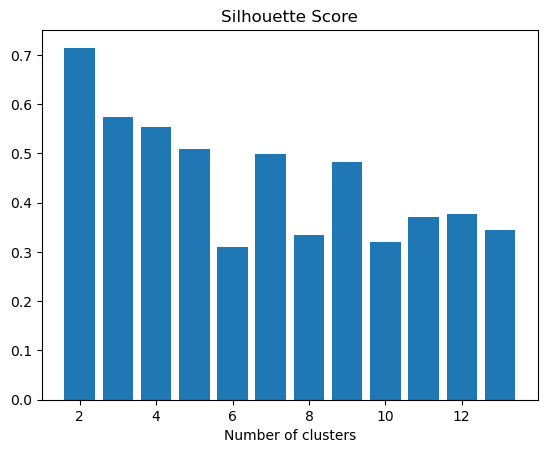

In [6]:
plt.bar(range(2,14),kmeans_sil_scores,)
plt.xlabel("Number of clusters")
plt.title("Silhouette Score")
# clusters =3 일때, silhouette score가 가장 높은것을 알 수 있음.

In [50]:
n_cluster=2
best_kmeans = KMeans(n_clusters=n_cluster,random_state=0)
cluster_labels=best_kmeans.fit_predict(label_1_scaled)
best_kmeans_sil_score=silhouette_score(label_1_scaled,cluster_labels)

print('Best kmeans clustering silhouette score:',best_kmeans_sil_score)

Best kmeans clustering silhouette score: 0.7144534943579282


c:\Users\choib\anaconda3\envs\iise-python\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [51]:
label_1['cluster']=cluster_labels
label_1

,r_1,n_5,r_5,r_9,r_12,n_171,r_171,n_172,r_172,n_173,...,r_194,r_195,n_196,r_196,r_197,r_198,r_199,n_175,r_175,cluster
476,4.294967e+09,98.0,2.0,40175.0,28.0,100.0,4.0,100.0,0.0,1.0,...,20.0,1.067805e+09,99.0,2.0,0.0,0.0,0.0,100.0,1.018337e+12,0
486,4.294967e+09,98.0,0.0,40012.0,59.0,100.0,0.0,100.0,0.0,1.0,...,16.0,2.260676e+09,100.0,0.0,0.0,0.0,0.0,100.0,1.005077e+12,0
1336,4.294967e+09,98.0,0.0,36922.0,30.0,100.0,0.0,100.0,0.0,1.0,...,18.0,1.591232e+09,100.0,0.0,0.0,0.0,0.0,100.0,9.407059e+11,0
1342,4.294967e+09,98.0,0.0,36522.0,28.0,100.0,0.0,100.0,0.0,83.0,...,14.0,2.791970e+08,100.0,0.0,0.0,0.0,0.0,100.0,9.280304e+11,0
1403,4.294967e+09,94.0,141.0,37481.0,30.0,99.0,70.0,100.0,0.0,1.0,...,8.0,2.748596e+09,97.0,141.0,0.0,0.0,0.0,100.0,9.497040e+11,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64872,4.294967e+09,96.0,0.0,44625.0,36.0,100.0,0.0,100.0,0.0,97.0,...,15.0,1.270160e+06,100.0,0.0,0.0,0.0,0.0,1.0,1.134050e+12,0
65353,4.294967e+09,98.0,0.0,44244.0,27.0,100.0,0.0,100.0,0.0,1.0,...,19.0,2.581993e+09,100.0,0.0,0.0,0.0,0.0,100.0,1.125316e+12,0
65429,4.294967e+09,98.0,0.0,40585.0,28.0,100.0,0.0,100.0,0.0,1.0,...,15.0,1.579518e+09,100.0,0.0,0.0,0.0,0.0,100.0,1.035432e+12,0
65911,4.294967e+09,98.0,0.0,42078.0,44.0,100.0,0.0,100.0,0.0,1.0,...,17.0,3.873290e+09,100.0,0.0,0.0,0.0,0.0,100.0,1.057160e+12,0


In [52]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(label_1)
label_1_pca = pca.transform(label_1)

In [53]:
# dim reduction with tsne
tsne = TSNE(random_state=42)
# use fit_transform instead of fit, as TSNE has no transform method. not be used as preprocessing step of supervised learning
label_1_tsne = tsne.fit_transform(label_1)

Text(0, 0.5, 'Second principal component')

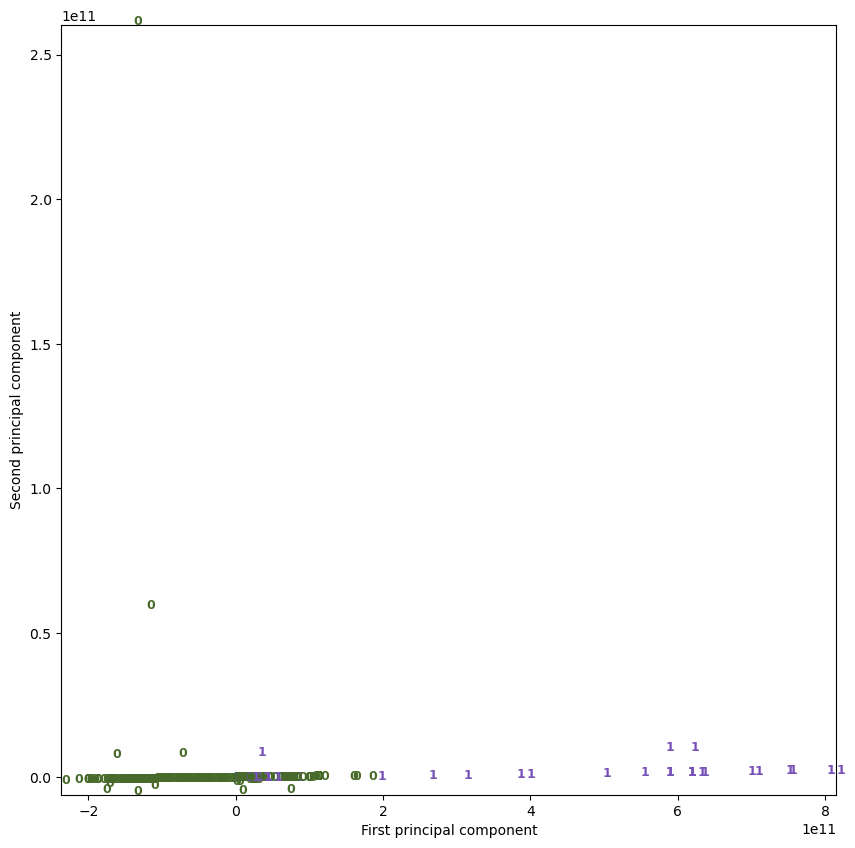

In [54]:
colors = ["#476A2A", "#7851B8", "#BD3430", "#4A2D4E", "#875525",
          "#A83683", "#4E655E", "#853541", "#3A3120", "#535D8E"]
plt.figure(figsize=(10, 10))
plt.xlim(label_1_pca[:, 0].min(), label_1_pca[:, 0].max())
plt.ylim(label_1_pca[:, 1].min(), label_1_pca[:, 1].max())
for i in range(len(label_1)):
    # actually plot the digits as text instead of using scatter
    plt.text(label_1_pca[i, 0], label_1_pca[i, 1], str(list(label_1['cluster'])[i]),
             color = colors[list(label_1['cluster'])[i]],
             fontdict={'weight': 'bold', 'size': 9})
plt.xlabel("First principal component")
plt.ylabel("Second principal component")
#중복되는 경우 많음. 난잡하게 섞여있다.

Text(0, 0.5, 'Second principal component')

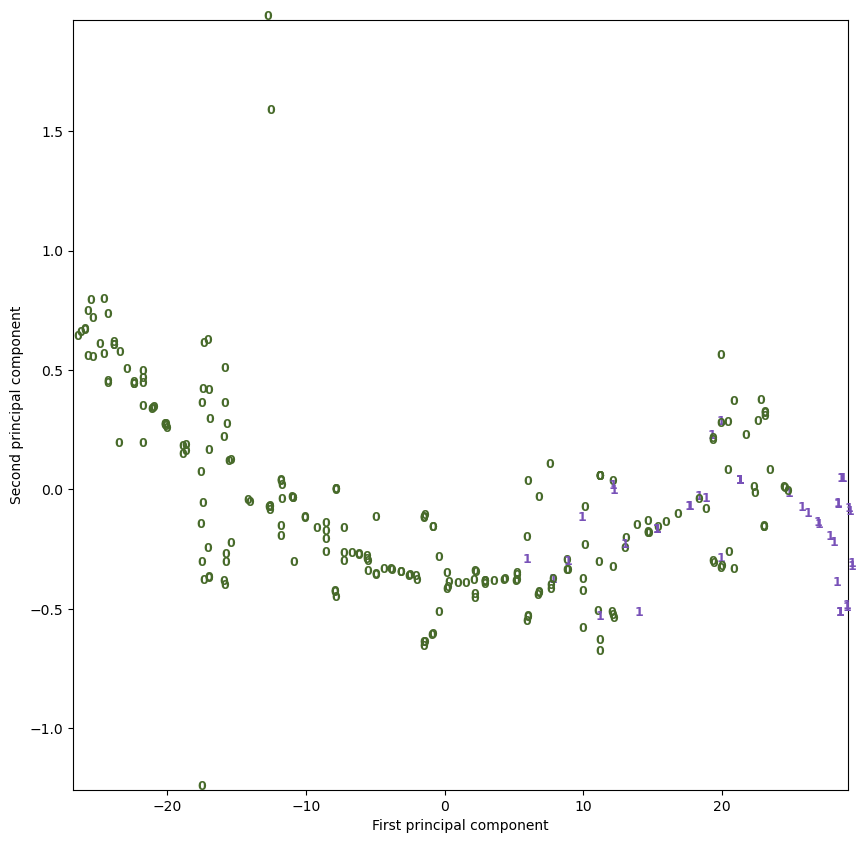

In [55]:
colors = ["#476A2A", "#7851B8", "#BD3430", "#4A2D4E", "#875525",
          "#A83683", "#4E655E", "#853541", "#3A3120", "#535D8E"]
plt.figure(figsize=(10, 10))
plt.xlim(label_1_tsne[:, 0].min(), label_1_tsne[:, 0].max())
plt.ylim(label_1_tsne[:, 1].min(), label_1_tsne[:, 1].max())
for i in range(len(label_1)):
    # actually plot the digits as text instead of using scatter
    plt.text(label_1_tsne[i, 0], label_1_tsne[i, 1], str(list(label_1['cluster'])[i]),
             color = colors[list(label_1['cluster'])[i]],
             fontdict={'weight': 'bold', 'size': 9})
plt.xlabel("First principal component")
plt.ylabel("Second principal component")
#상대적으로 잘 뭉쳐져있다! -> 시각화하는데 잘 사용됨.

## Clustering Algorithm(2)- Agglomerative Clustering

In [13]:
from sklearn.cluster import AgglomerativeClustering

agg_sil_scores=[]
#ward,complete,average,single -> 선택
linkages = ['ward','complete','average','single']
for linkage in linkages:
    linkage_sil_scores =[]
    for n_cluster in range(2,14):
        agg = AgglomerativeClustering(n_clusters=n_cluster,linkage=linkage)
        agg.fit(label_1_scaled)
        cluster_labels=agg.labels_
        linkage_sil_scores.append(silhouette_score(label_1_scaled,cluster_labels))
    agg_sil_scores.append(linkage_sil_scores)


In [14]:
agg_sil_scores=np.stack(agg_sil_scores)
for i in range(4):
    print('{}의 최대 silhouette score :{}'.format(linkages[i],agg_sil_scores[i].max()))
#ward의 silhouette score가 가장 높음 -> ward를 선택

ward의 최대 silhouette score :0.7144534943579282
complete의 최대 silhouette score :0.7144534943579282
average의 최대 silhouette score :0.7144534943579282
single의 최대 silhouette score :0.7144534943579282


Text(0.5, 1.0, 'Silhouette Score')

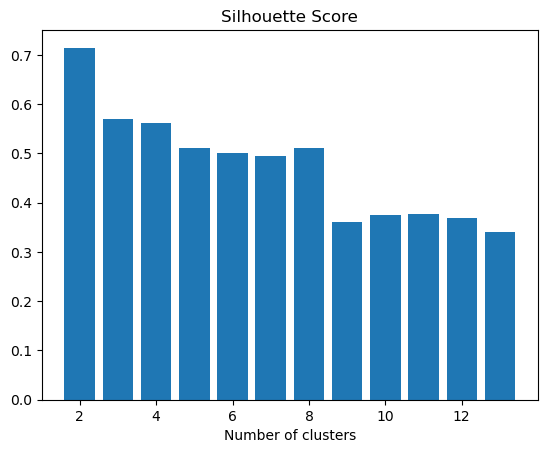

In [15]:
plt.bar(range(2,14),agg_sil_scores[0],)
plt.xlabel("Number of clusters")
plt.title("Silhouette Score")

In [41]:
n_cluster = 2
linkage='ward'
best_agg = AgglomerativeClustering(n_clusters=n_cluster,linkage=linkage)
best_agg.fit(label_1_scaled)
best_agg_sil_score=silhouette_score(label_1_scaled,best_agg.labels_)
print('Best agglomerative clustering silhouette score:',best_agg_sil_score)

Best agglomerative clustering silhouette score: 0.7144534943579282


In [42]:
cluster_labels=best_agg.fit_predict(label_1_scaled)

In [43]:
label_1['cluster']=cluster_labels
label_1

,r_1,n_5,r_5,r_9,r_12,n_171,r_171,n_172,r_172,n_173,...,r_194,r_195,n_196,r_196,r_197,r_198,r_199,n_175,r_175,cluster
476,4.294967e+09,98.0,2.0,40175.0,28.0,100.0,4.0,100.0,0.0,1.0,...,20.0,1.067805e+09,99.0,2.0,0.0,0.0,0.0,100.0,1.018337e+12,0
486,4.294967e+09,98.0,0.0,40012.0,59.0,100.0,0.0,100.0,0.0,1.0,...,16.0,2.260676e+09,100.0,0.0,0.0,0.0,0.0,100.0,1.005077e+12,0
1336,4.294967e+09,98.0,0.0,36922.0,30.0,100.0,0.0,100.0,0.0,1.0,...,18.0,1.591232e+09,100.0,0.0,0.0,0.0,0.0,100.0,9.407059e+11,0
1342,4.294967e+09,98.0,0.0,36522.0,28.0,100.0,0.0,100.0,0.0,83.0,...,14.0,2.791970e+08,100.0,0.0,0.0,0.0,0.0,100.0,9.280304e+11,0
1403,4.294967e+09,94.0,141.0,37481.0,30.0,99.0,70.0,100.0,0.0,1.0,...,8.0,2.748596e+09,97.0,141.0,0.0,0.0,0.0,100.0,9.497040e+11,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64872,4.294967e+09,96.0,0.0,44625.0,36.0,100.0,0.0,100.0,0.0,97.0,...,15.0,1.270160e+06,100.0,0.0,0.0,0.0,0.0,1.0,1.134050e+12,0
65353,4.294967e+09,98.0,0.0,44244.0,27.0,100.0,0.0,100.0,0.0,1.0,...,19.0,2.581993e+09,100.0,0.0,0.0,0.0,0.0,100.0,1.125316e+12,0
65429,4.294967e+09,98.0,0.0,40585.0,28.0,100.0,0.0,100.0,0.0,1.0,...,15.0,1.579518e+09,100.0,0.0,0.0,0.0,0.0,100.0,1.035432e+12,0
65911,4.294967e+09,98.0,0.0,42078.0,44.0,100.0,0.0,100.0,0.0,1.0,...,17.0,3.873290e+09,100.0,0.0,0.0,0.0,0.0,100.0,1.057160e+12,0


In [44]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(label_1)
label_1_pca = pca.transform(label_1)

In [45]:
# dim reduction with tsne
tsne = TSNE(random_state=42)
# use fit_transform instead of fit, as TSNE has no transform method. not be used as preprocessing step of supervised learning
label_1_tsne = tsne.fit_transform(label_1)

Text(0, 0.5, 'Second principal component')

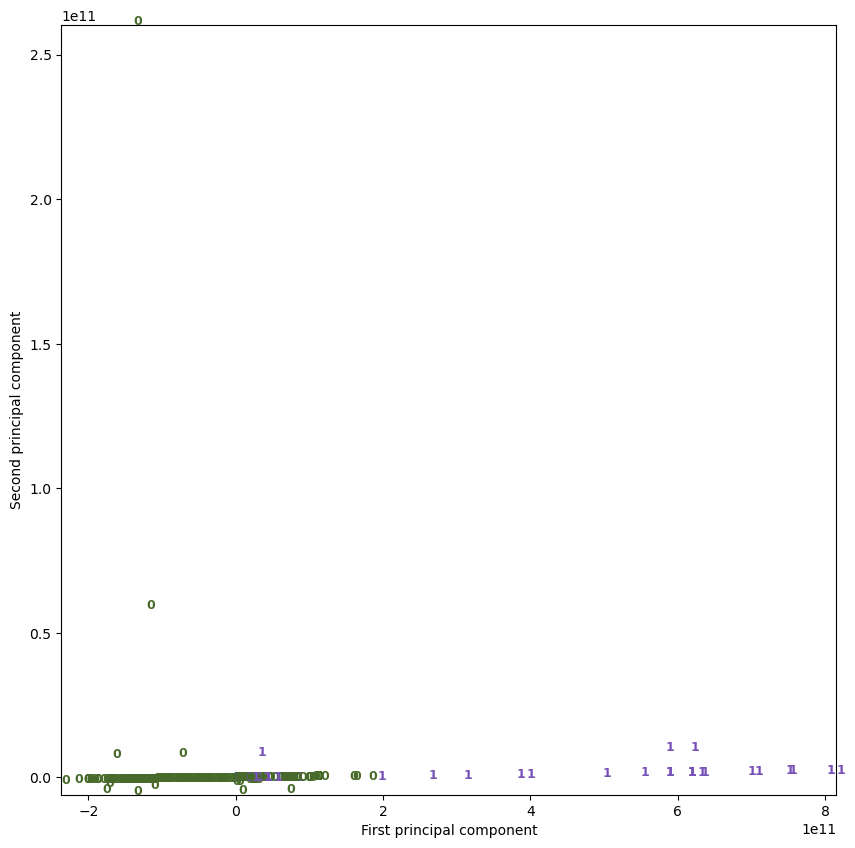

In [46]:
colors = ["#476A2A", "#7851B8", "#BD3430", "#4A2D4E", "#875525",
          "#A83683", "#4E655E", "#853541", "#3A3120", "#535D8E"]
plt.figure(figsize=(10, 10))
plt.xlim(label_1_pca[:, 0].min(), label_1_pca[:, 0].max())
plt.ylim(label_1_pca[:, 1].min(), label_1_pca[:, 1].max())
for i in range(len(label_1)):
    # actually plot the digits as text instead of using scatter
    plt.text(label_1_pca[i, 0], label_1_pca[i, 1], str(list(label_1['cluster'])[i]),
             color = colors[list(label_1['cluster'])[i]],
             fontdict={'weight': 'bold', 'size': 9})
plt.xlabel("First principal component")
plt.ylabel("Second principal component")
#중복되는 경우 많음. 난잡하게 섞여있다.

Text(0, 0.5, 'Second principal component')

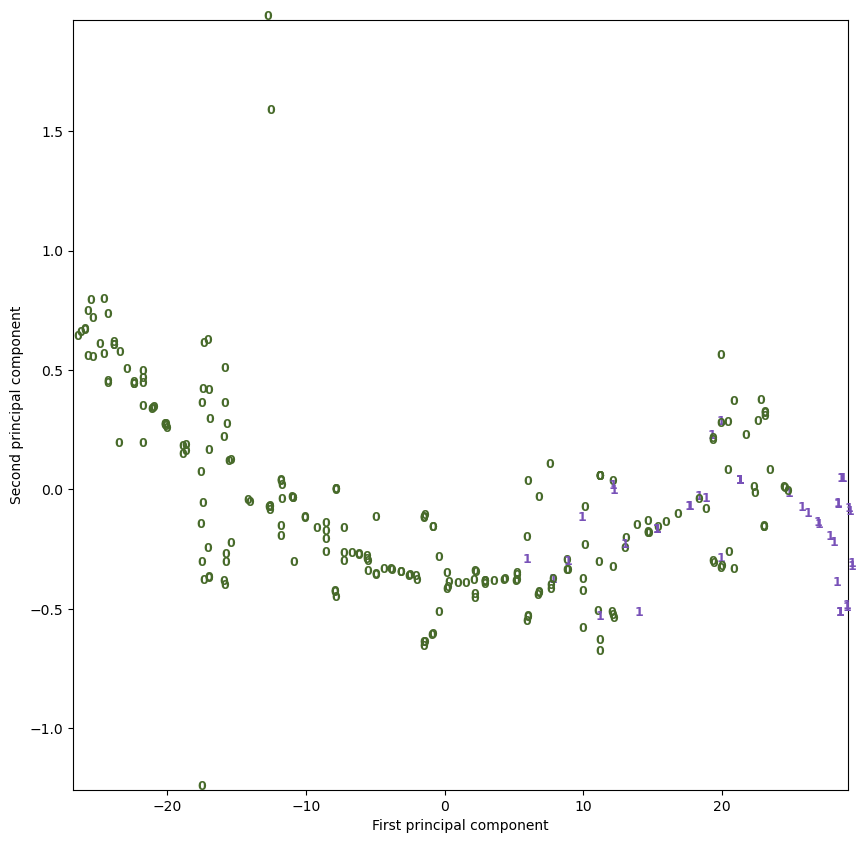

In [47]:
colors = ["#476A2A", "#7851B8", "#BD3430", "#4A2D4E", "#875525",
          "#A83683", "#4E655E", "#853541", "#3A3120", "#535D8E"]
plt.figure(figsize=(10, 10))
plt.xlim(label_1_tsne[:, 0].min(), label_1_tsne[:, 0].max())
plt.ylim(label_1_tsne[:, 1].min(), label_1_tsne[:, 1].max())
for i in range(len(label_1)):
    # actually plot the digits as text instead of using scatter
    plt.text(label_1_tsne[i, 0], label_1_tsne[i, 1], str(list(label_1['cluster'])[i]),
             color = colors[list(label_1['cluster'])[i]],
             fontdict={'weight': 'bold', 'size': 9})
plt.xlabel("First principal component")
plt.ylabel("Second principal component")
#상대적으로 잘 뭉쳐져있다! -> 시각화하는데 잘 사용됨.

## Clustering Algorithm(3) - DBSCAN

In [23]:
from sklearn.cluster import DBSCAN

eps_list=[1,1.5,1.8,2,2.5]
min_samples=[2,3,4,5,6,7]

dbscan_sil_scores =[]

for eps in eps_list:
    dbscan_sil=[]
    for ms in min_samples:
        dbscan = DBSCAN(eps=eps,min_samples=ms)
        dbscan.fit(label_1_scaled)
        cluster_labels = dbscan.labels_
        dbscan_sil.append(silhouette_score(label_1_scaled,cluster_labels))
    dbscan_sil_scores.append(dbscan_sil)

dbscan_sil_scores=np.stack(dbscan_sil_scores)
dbscan_sil_scores

array([[0.55245542, 0.55245542, 0.56064012, 0.56064012, 0.56064012,
        0.56064012],
       [0.68014128, 0.68014128, 0.68014128, 0.68014128, 0.68014128,
        0.68014128],
       [0.68014128, 0.68014128, 0.68014128, 0.68014128, 0.68014128,
        0.68014128],
       [0.71445349, 0.71445349, 0.71445349, 0.71445349, 0.71445349,
        0.71445349],
       [0.71445349, 0.71445349, 0.71445349, 0.71445349, 0.71445349,
        0.71445349]])

In [24]:
max_scores=[]
for i in range(len(eps_list)):
    max_scores.append(dbscan_sil_scores[i].max())
max_index=max_scores.index(max(max_scores))

print('silhouette score의 최대:',max_scores[max_index])
print('silhouette score가 최대일때, eps:',eps_list[max_index])

silhouette score의 최대: 0.7144534943579282
silhouette score가 최대일때, eps: 2


In [37]:
best_dbscan=DBSCAN(eps=2,min_samples=3)
best_dbscan.fit(label_1_scaled)
best_dbscan_sil_score=silhouette_score(label_1_scaled,best_dbscan.labels_)
print('Best DBSCAN clustering silhouette score:',best_dbscan_sil_score)

Best DBSCAN clustering silhouette score: 0.7144534943579282


In [38]:
label_1['cluster']=best_dbscan.fit_predict(label_1_scaled)
label_1

,r_1,n_5,r_5,r_9,r_12,n_171,r_171,n_172,r_172,n_173,...,r_194,r_195,n_196,r_196,r_197,r_198,r_199,n_175,r_175,cluster
476,4.294967e+09,98.0,2.0,40175.0,28.0,100.0,4.0,100.0,0.0,1.0,...,20.0,1.067805e+09,99.0,2.0,0.0,0.0,0.0,100.0,1.018337e+12,0
486,4.294967e+09,98.0,0.0,40012.0,59.0,100.0,0.0,100.0,0.0,1.0,...,16.0,2.260676e+09,100.0,0.0,0.0,0.0,0.0,100.0,1.005077e+12,0
1336,4.294967e+09,98.0,0.0,36922.0,30.0,100.0,0.0,100.0,0.0,1.0,...,18.0,1.591232e+09,100.0,0.0,0.0,0.0,0.0,100.0,9.407059e+11,0
1342,4.294967e+09,98.0,0.0,36522.0,28.0,100.0,0.0,100.0,0.0,83.0,...,14.0,2.791970e+08,100.0,0.0,0.0,0.0,0.0,100.0,9.280304e+11,0
1403,4.294967e+09,94.0,141.0,37481.0,30.0,99.0,70.0,100.0,0.0,1.0,...,8.0,2.748596e+09,97.0,141.0,0.0,0.0,0.0,100.0,9.497040e+11,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64872,4.294967e+09,96.0,0.0,44625.0,36.0,100.0,0.0,100.0,0.0,97.0,...,15.0,1.270160e+06,100.0,0.0,0.0,0.0,0.0,1.0,1.134050e+12,0
65353,4.294967e+09,98.0,0.0,44244.0,27.0,100.0,0.0,100.0,0.0,1.0,...,19.0,2.581993e+09,100.0,0.0,0.0,0.0,0.0,100.0,1.125316e+12,0
65429,4.294967e+09,98.0,0.0,40585.0,28.0,100.0,0.0,100.0,0.0,1.0,...,15.0,1.579518e+09,100.0,0.0,0.0,0.0,0.0,100.0,1.035432e+12,0
65911,4.294967e+09,98.0,0.0,42078.0,44.0,100.0,0.0,100.0,0.0,1.0,...,17.0,3.873290e+09,100.0,0.0,0.0,0.0,0.0,100.0,1.057160e+12,0


In [39]:
label_1['cluster'].value_counts()

0    229
1     46
Name: cluster, dtype: int64

<BarContainer object of 3 artists>

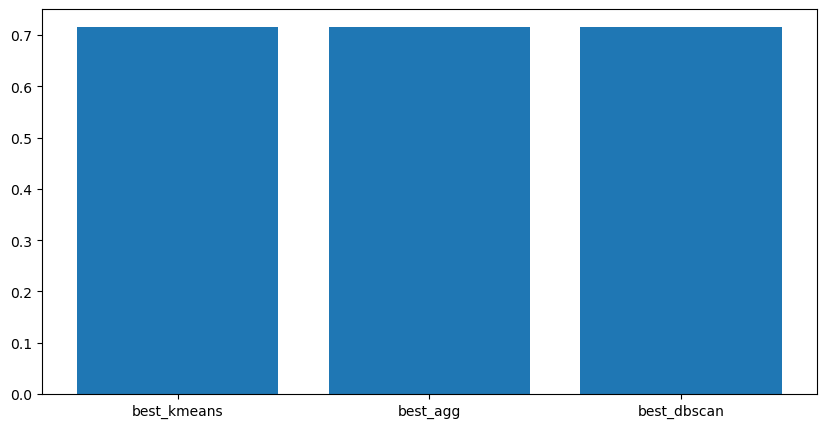

In [57]:
clusterings_sil_scores = [best_kmeans_sil_score,best_agg_sil_score,best_dbscan_sil_score]
cluster_names = ['best_kmeans','best_agg','best_dbscan']
plt.figure(figsize=(10,5))
plt.bar(cluster_names,clusterings_sil_scores,)

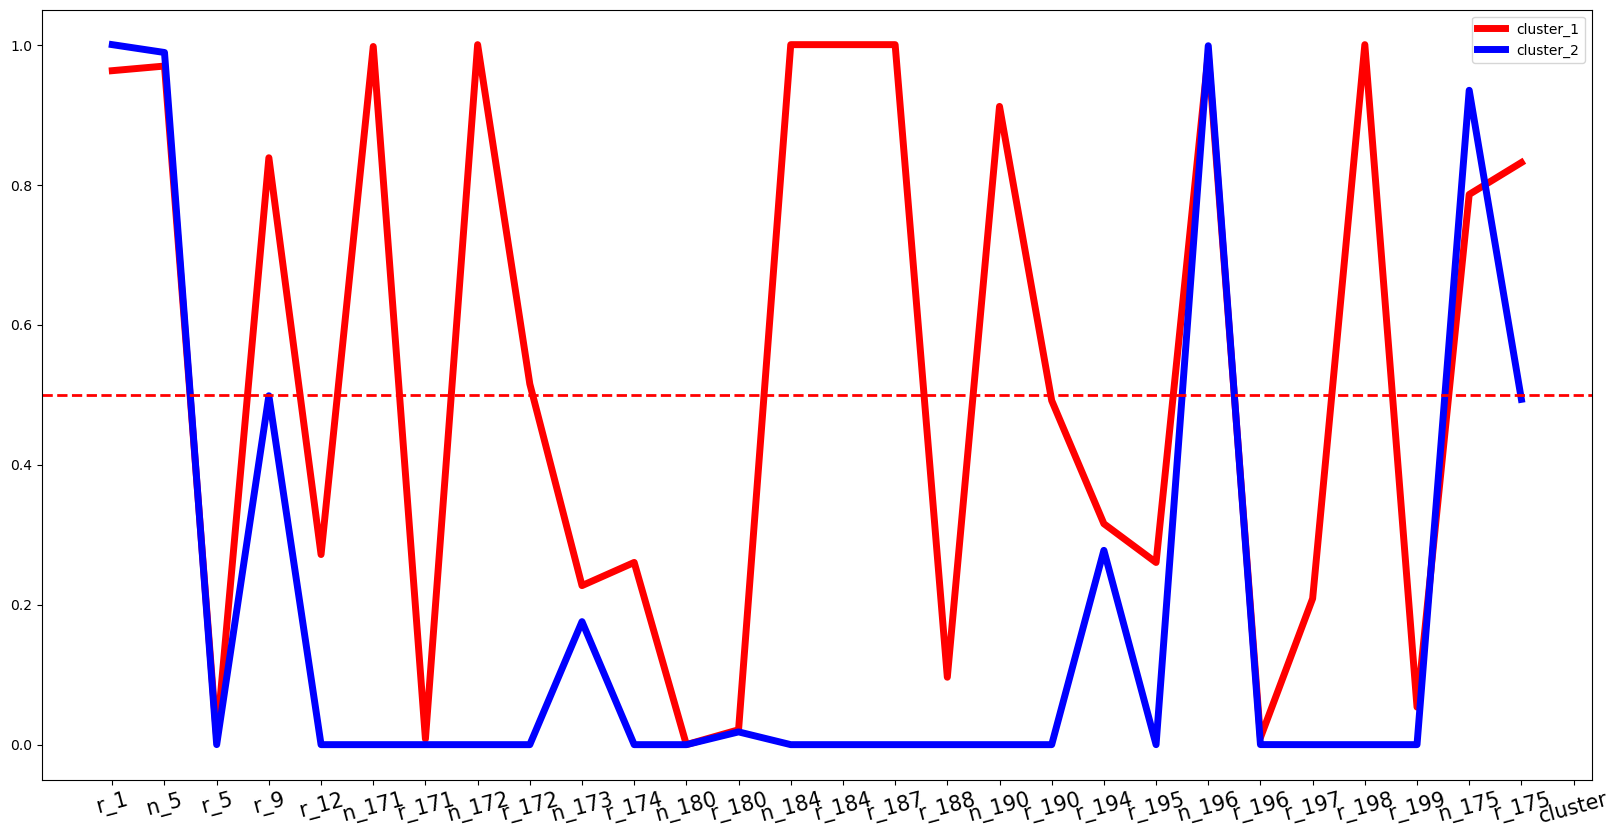

In [56]:
plt.figure(figsize=(20,10))

plt.plot(range(0,28),best_kmeans.cluster_centers_[0],linewidth=5, color='red', label='cluster_1')
plt.plot(range(0,28),best_kmeans.cluster_centers_[1], linewidth=5, color='blue', label='cluster_2')
plt.legend()
plt.axhline(0.5, color='red', linestyle='--', linewidth=2)
plt.xticks(np.arange(0,29),label_1.columns,rotation=15 ,fontsize=15)
plt.show()

In [31]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(label_1)
label_1_pca = pca.transform(label_1)

In [32]:
# dim reduction with tsne
tsne = TSNE(random_state=42)
# use fit_transform instead of fit, as TSNE has no transform method. not be used as preprocessing step of supervised learning
label_1_tsne = tsne.fit_transform(label_1)

Text(0, 0.5, 'Second principal component')

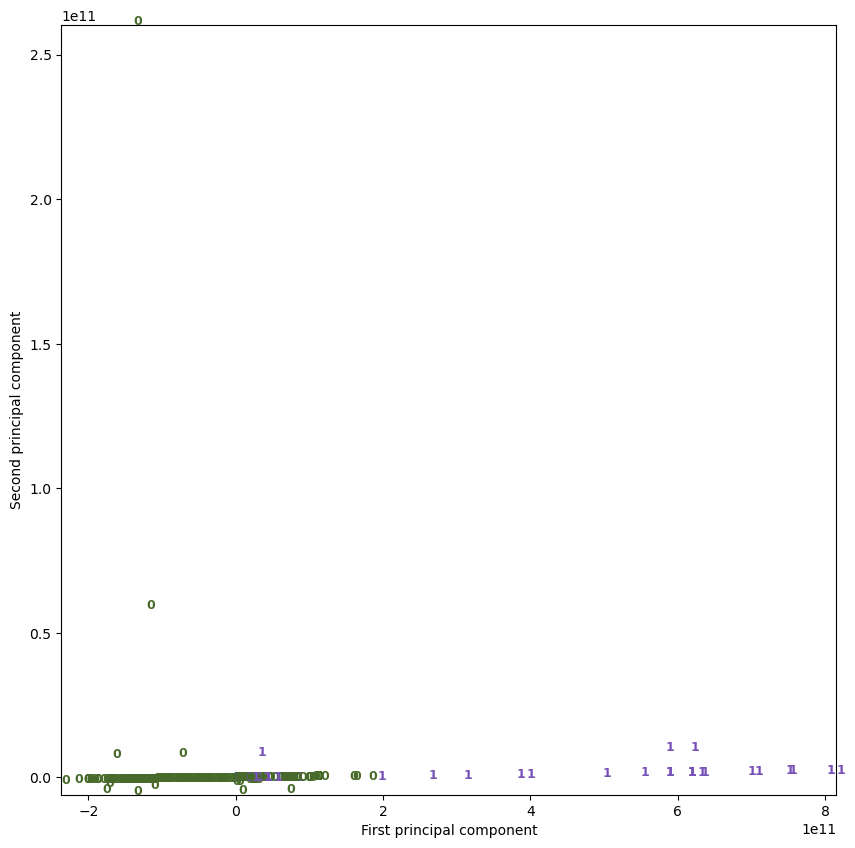

In [58]:
colors = ["#476A2A", "#7851B8", "#BD3430", "#4A2D4E", "#875525",
          "#A83683", "#4E655E", "#853541", "#3A3120", "#535D8E"]
plt.figure(figsize=(10, 10))
plt.xlim(label_1_pca[:, 0].min(), label_1_pca[:, 0].max())
plt.ylim(label_1_pca[:, 1].min(), label_1_pca[:, 1].max())
for i in range(len(label_1)):
    # actually plot the digits as text instead of using scatter
    plt.text(label_1_pca[i, 0], label_1_pca[i, 1], str(list(label_1['cluster'])[i]),
             color = colors[list(label_1['cluster'])[i]],
             fontdict={'weight': 'bold', 'size': 9})
plt.xlabel("First principal component")
plt.ylabel("Second principal component")
#중복되는 경우 많음. 난잡하게 섞여있다.

Text(0, 0.5, 'Second principal component')

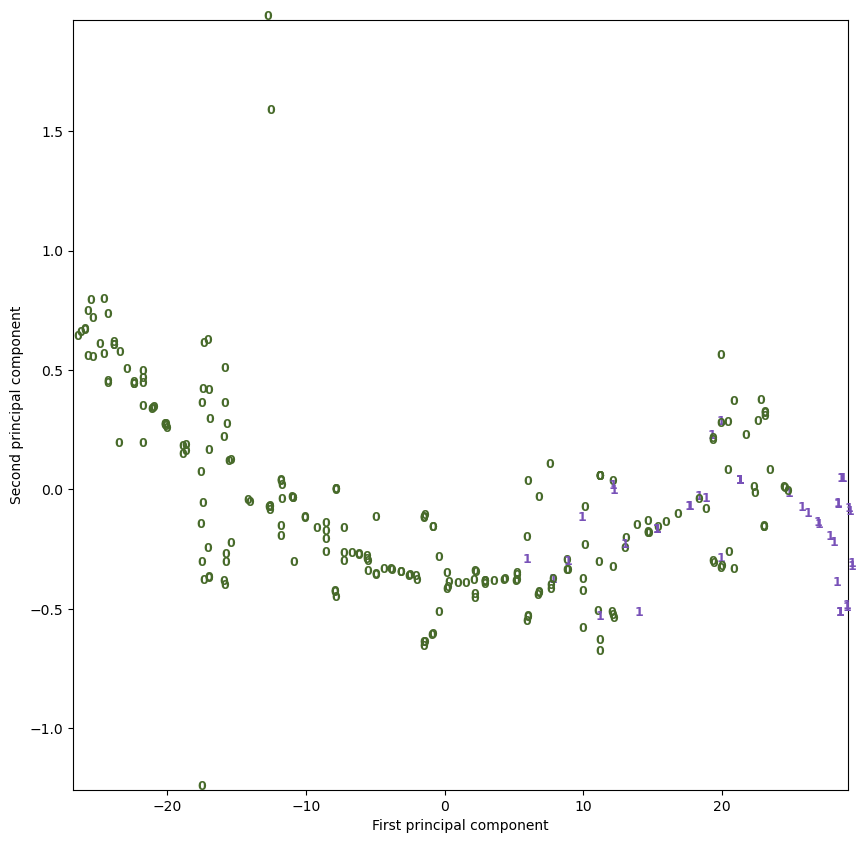

In [59]:
colors = ["#476A2A", "#7851B8", "#BD3430", "#4A2D4E", "#875525",
          "#A83683", "#4E655E", "#853541", "#3A3120", "#535D8E"]
plt.figure(figsize=(10, 10))
plt.xlim(label_1_tsne[:, 0].min(), label_1_tsne[:, 0].max())
plt.ylim(label_1_tsne[:, 1].min(), label_1_tsne[:, 1].max())
for i in range(len(label_1)):
    # actually plot the digits as text instead of using scatter
    plt.text(label_1_tsne[i, 0], label_1_tsne[i, 1], str(list(label_1['cluster'])[i]),
             color = colors[list(label_1['cluster'])[i]],
             fontdict={'weight': 'bold', 'size': 9})
plt.xlabel("First principal component")
plt.ylabel("Second principal component")
#상대적으로 잘 뭉쳐져있다! -> 시각화하는데 잘 사용됨.